In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import json
import os
import sys
import pickle
from scipy import ndimage

# for Jupyter lab
# %matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline


lib_path = os.path.abspath(os.path.join('..','..','Libraries'))
sys.path.append(lib_path)
Fun4all_path = os.path.abspath(os.path.join('..','..','..','..'))
sys.path.append(Fun4all_path)

from pyFunsForAll.plot_fun import colorize, adjust_lightness, get_blue_map, get_red_map
from pyFunsForAll.analy_fun import cpx_corr, fidelity, seq_cpx_corr, get_disk_mask
from pyFunsForAll.rand_fun import rnd_cpx_disk

from pyTen.decompositions import get_HOSvec, hosvd, als3herm, als4herm2
from fisher_functions import get_W3, get_W4, normalizevecs,\
    getOutputFields, fisherPerMode, fisher, get_moim, derYop
from optimize_fisher import optimize_input

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 


plt.rc('figure', facecolor='white') # white background for VSC
cmap_int = 'afmhot'#'gist_heat'
cmap_fish = 'inferno'

function = fidelity
noise = 'gaussian'#'poisson'

# data_path = os.path.abspath(os.path.join('..','..','MyData')) #pc
# data_path = 'C:\\Users\\Manip\\Documents\\Projects\\TM_measurements\\Rodrigo\\MMF_codes\\Memory_effect\\Treated_data\\SI'
# data_path = os.path.abspath(os.path.join('..','..','..','My_data','GRIN')) #mac
# fig_path = os.path.abspath(os.path.join('..','Figs'))
# fig_path = os.path.abspath(os.path.join('..','..','Manuscript','Figs'))

data_path = os.path.abspath(os.path.join('..','Results','GRIN')) 
fig_path = os.path.abspath(os.path.join('Figures','GRIN'))

In [3]:
cmap_int = 'gray'#'gist_heat'#matplotlib.cm.get_cmap('gist_heat_r')#'hot'#'gist_heat'
cmap_fish = 'inferno'#'magma'#'inferno'

In [4]:
# i=2
# crnd = plt.cm.tab10(4)#adjust_lightness('b', amount=1.2)
# cmod = plt.cm.tab10(0)#adjust_lightness('purple', amount=1.5)
# ccra = plt.cm.tab10(1)#adjust_lightness('r', amount=1.2)
# cmii = plt.cm.tab10(3)#'orange'

cmcra = matplotlib.cm.get_cmap('Oranges')
cmrnd = matplotlib.cm.get_cmap('Purples')
cmmod = matplotlib.cm.get_cmap('Blues')
cmmii = matplotlib.cm.get_cmap('Reds')

crnd = cmrnd(1.)#adjust_lightness('b', amount=1.2)
cmod = cmmod(0.8)#adjust_lightness('purple', amount=1.5)
ccra = cmcra(0.7)#adjust_lightness('r', amount=1.2)
cmii = cmmii(0.8)#

In [5]:
def get_corrVSdx(Xs, TMs, TMref, mask=None, remove_mean=False, inten=False, normalize=True):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    if inten==True:
        Ydx = np.abs(Ydx)**2
        Yref = np.abs(Yref)**2
    sh = Ydx.shape
    if len(sh)==2:
        corr = seq_cpx_corr(Ydx,Yref, mask=mask, remove_mean=remove_mean, normalize=normalize)
    else:
        corr = np.empty(Ydx.shape[:2], complex)
        for i in range(Ydx.shape[1]):
            corr[:,i] = seq_cpx_corr(Ydx[:,i],Yref[i], mask=mask, remove_mean=remove_mean, normalize=normalize)
    return corr

def get_miis(init_seeds, Hs, n_iter=200, method='als'):
    fout = 0
    W_ten = get_W3(Hs, method='2pts')
    for n, seed in enumerate(init_seeds):
        if method == 'opt':
            F, X, evol = optimize_input(
                seed, Hs, n_epochs=n_iter,lr=1e-2,noise='gaussian')
        elif method == 'als':
            us_als, evol = als3herm(
                W_ten, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
            X = us_als[2][:,0]
            F = fisher(X, Hs, noise='gaussian')
        else:
            raise ValueError('Invalid method')
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol, nseed

def get_lim(init_seeds, Hs, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        F, X, evol = optimize_input(
            seed, Hs, n_epochs=n_iter,lr=1e-2,noise='moim')
        
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n

    return fout, xout, evol_out, nseed

def get_b1o_np(init_seeds, Hs, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        F, X, evol = optimize_input(
            seed, Hs, n_epochs=n_iter,lr=1e-2,noise='b1o')
        
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n

    return fout, xout, evol_out, nseed

def get_best1out(init_seeds, Hs, W4, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        us_als, evol = als4herm2(
            W4, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
        X = us_als[3][:,0]
        moim = get_moim(X,Hs)
        F = moim[1][1]**2
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol, nseed

# 1. Load data

In [6]:
with open(os.path.join(data_path, 'param.pkl'), 'rb') as file:
        param = pickle.load(file, encoding='latin1')

In [7]:
param['input_fields']['n_vec']

7200

In [10]:
param['TMpix']['nroot']

38

In [9]:
param['inlayout']['cell_size']

20

In [11]:
61*20

1220

In [8]:
TMlist4corr = np.load(os.path.join(data_path,'TMlist4corr.npy'))
dx4corr = np.load(os.path.join(data_path,'poslist4corr.npy'))
TMs4modes = np.load(os.path.join(data_path,'TM_3pts2computemodes.npy'))
dx4modes = np.load(os.path.join(data_path,'pos2nd_3pts.npy'))

In [9]:
N_in = param['TMpix']['mroot']
N_out = param['TMpix']['nroot'] 
n_mod = np.shape(TMlist4corr)[-1]

def horz_reshp(vec):
    p1 = vec[:N_out**2].reshape(N_out,N_out)
    p2 = vec[N_out**2:].reshape(N_out,N_out)
    return np.concatenate((p1,p2),axis=1)

In [10]:
TMpix = np.load(os.path.join(data_path,'TMpix.npy'))

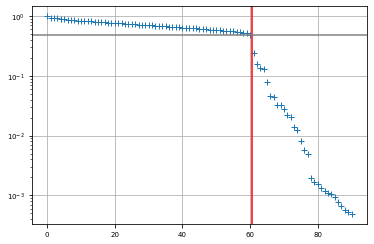

In [11]:
u, s, vh = np.linalg.svd(TMpix)
fig,ax = plt.subplots(1, 1)
ax.semilogy((s[:int(n_mod*1.5)]/s[0])**2,'+')
ax.axvline(n_mod-.5,c='r')
ax.axhline((s[n_mod-1]/s[0])**2,c='gray')
ax.grid(True)

# 2. Sensitivity to deformation

## 2.1 Compute crashing modes and MIIS

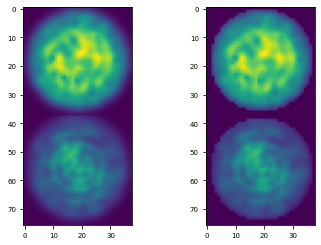

In [12]:
n_rnd = 100
X_rnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Yrnd = getOutputFields(X_rnd,TMlist4corr[0])

out_mask = get_disk_mask([N_out,N_out], 0.96*N_out//2, center=(N_out/2-1,N_out/2))
out_mask = np.concatenate((out_mask,out_mask), axis=0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(np.mean(np.abs(Yrnd)**2,axis=0),(2*N_out,N_out)))
ax[1].imshow(out_mask*np.reshape(np.mean(np.abs(Yrnd)**2,axis=0),(2*N_out,N_out)))

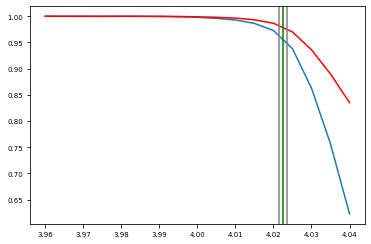

In [13]:
# central deformation to estimate the WS operator
center_TM_index = 11

fig,ax = plt.subplots(1, 1)
ax.plot(dx4corr,fidelity(TMlist4corr,TMlist4corr[0]))
ax.plot(dx4corr,fidelity(np.abs(TMlist4corr),np.abs(TMlist4corr[0])),c='r')
ax.axvline(dx4modes[1],c='g')
ax.axvline(dx4modes[0],c='gray')
ax.axvline(dx4modes[2],c='gray')


In [14]:
W_ten = get_W3(TMs4modes, method='2pts') # should be less susceptible to phase errors
us_hosvd, s_hosvd = hosvd(W_ten)
Xcrash = us_hosvd[2].T

opt_seeds = [us_hosvd[2][:,i] for i in range(5)]
als_seeds = [[np.sum(s_hosvd[:,i,i]*us_hosvd[0],axis=-1,keepdims=True),us_hosvd[1][:,i,None],us_hosvd[2][:,i,None]]
    for i in range(5)] # iter = 80
Fmiis, Xmiis, evol, nseed = \
    get_miis(opt_seeds, TMs4modes[::2], n_iter=400, method='opt')

n_rnd = 100
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Xmod = np.eye(n_mod, dtype=complex)[:n_mod]

Fcrash = fisher(Xcrash, TMs4modes, noise=noise)
Frnd = fisher(Xrnd, TMs4modes, noise=noise)
Fmod = fisher(Xmod, TMs4modes, noise=noise)

In [236]:
from numba import jit

In [292]:
@jit(nopython=True)
def get_inW4(w3):
    m = w3.shape[-1]
    inw4 = np.empty([m]*4, dtype=np.complex128)
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for l in range(m):
                    inw4[i,j,k,l] = np.sum((w3[:,i,j]*w3[:,k,l]), axis=0)
    return inw4

In [586]:

@jit(nopython=True)
def empty(x):
    m = x.shape[-1]
    return np.empty((2,2,2,2),  dtype=np.complex64)  # np.float64 instead of np.float

empty(np.array([[1,2,3],[2,3,1]]))

array([[[[-26711958.-26711958.j, -26711958.-26711958.j],
         [-26711958.-26711958.j, -26711958.-26711958.j]],

        [[-26711958.-26711958.j, -26711958.-26711958.j],
         [-26711958.-26711958.j, -26711958.-26711958.j]]],


       [[[-26711958.-26711958.j, -26711958.-26711958.j],
         [-26711958.-26711958.j, -26711958.-26711958.j]],

        [[-26711958.-26711958.j, -26711958.-26711958.j],
         [-26711958.-26711958.j, -26711958.-26711958.j]]]],
      dtype=complex64)

In [293]:
inW4 = get_inW4(W_ten)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function empty>) found for signature:
 
 >>> empty(list(int64)<iv=None>, dtype=class(complex128))
 
There are 4 candidate implementations:
[1m      - Of which 4 did not match due to:
      Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 131.
        With argument(s): '(list(int64)<iv=None>, dtype=class(complex128))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       [1m[1m[1mNo implementation of function Function(<intrinsic stub>) found for signature:
        
        >>> stub(list(int64)<iv=None>, class(complex128))
        
       There are 2 candidate implementations:
       [1m  - Of which 2 did not match due to:
         Intrinsic of function 'stub': File: numba\core\overload_glue.py: Line 35.
           With argument(s): '(list(int64)<iv=None>, class(complex128))':[0m
       [1m   No match.[0m
       [0m
       [0m[1mDuring: resolving callee type: Function(<intrinsic stub>)[0m
       [0m[1mDuring: typing of call at <string> (3)
       [0m
       [1m
       File "<string>", line 3:[0m
       [1m<source missing, REPL/exec in use?>[0m
[0m
  raised from c:\Users\Manip\.conda\envs\mmf\lib\site-packages\numba\core\typeinfer.py:1086
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function empty>)[0m
[0m[1mDuring: typing of call at C:\Users\Manip\AppData\Local\Temp\ipykernel_13180\215660874.py (4)
[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_13180\215660874.py", line 4:[0m
[1m<source missing, REPL/exec in use?>[0m


In [284]:
us_hosvd_inw4 = get_HOSvec(inW4,2)
Xcrash_inw4 = us_hosvd_inw4.T

In [251]:
Fcrash_inw4 = fisher(Xcrash_inw4, TMs4modes, noise=noise)

In [280]:
Yints_inw4 = np.abs(getOutputFields(Xcrash_inw4, TMs4fieldplot))**2
Yints_inw3 = np.abs(getOutputFields(Xcrash, TMs4fieldplot))**2

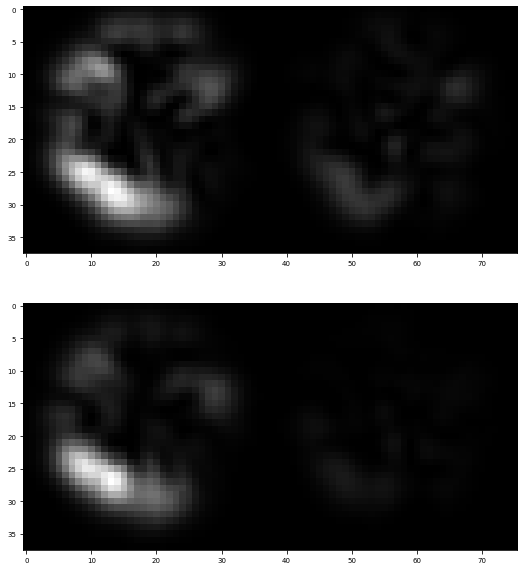

In [278]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ind_c = 0
ax[0].imshow(horz_reshp(Yints_inw3[0,ind_c]),vmin=0,cmap=cmap_int,
                            interpolation='none')
ax[1].imshow(horz_reshp(Yints_inw4[0,ind_c]),vmin=0,cmap=cmap_int,
                            interpolation='none')

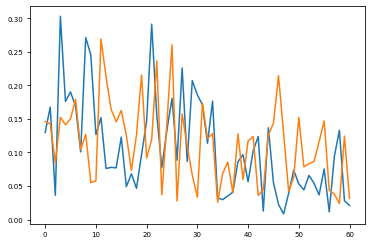

In [254]:
plt.plot(np.abs(Xcrash[2]))
plt.plot(np.abs(Xcrash_inw4[3]))

In [123]:
maskc = None # 
intc = True
rm=True #False
nrm=True
corr_mod = np.abs(get_corrVSdx(Xmod, TMlist4corr,TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_crash = np.abs(get_corrVSdx(Xcrash, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_rnd = np.abs(get_corrVSdx(Xrnd, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_miis = np.abs(get_corrVSdx(Xmiis, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))

In [269]:
corr_crash_inw4 = np.abs(get_corrVSdx(Xcrash_inw4, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))

In [116]:
np.argmin(corr_mod[-1])

60

Text(0, 0.5, 'Intensity correlation')

<Figure size 252x158.4 with 0 Axes>

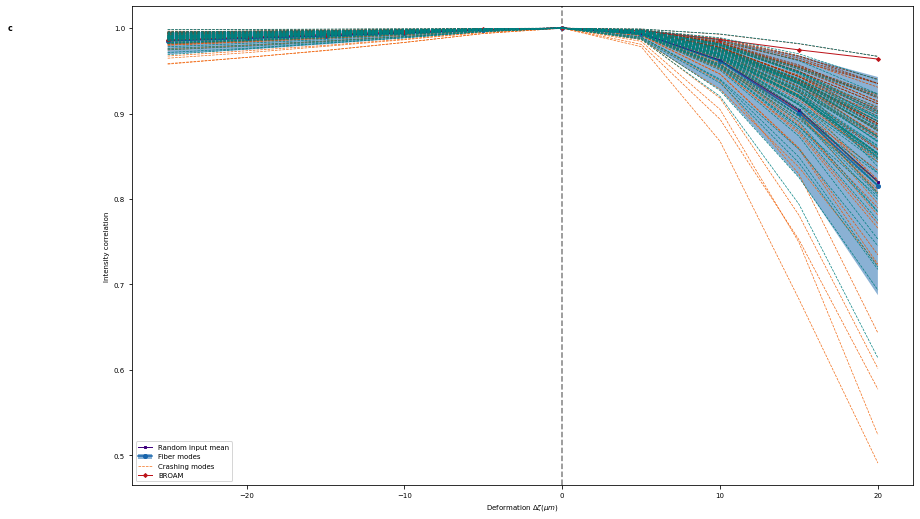

In [270]:
i0 = 7#center_TM_index-2#5#18
plt.figure(figsize = (3.5,2.2))
zf = 4
plt.figure(figsize = (zf*3.5,zf*2.2))
n_mod2p = n_mod#//3
n_cra2p = n_mod
ms = 4 #8
lw=0.7
dxp = (dx4corr[i0:] - dx4corr[12])*1000



plt.gca().axvline(0, c='gray', linestyle = 'dashed')
# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

ln3, = plt.plot(dxp, corr_crash[i0:,0], c=cmcra(0.6), ls='--', lw=lw,label='Crashing modes')
for i in range(1,n_cra2p):
    plt.plot(dxp, corr_crash[i0:,i], c=cmcra(0.6+0.4*i/n_cra2p), ls='--', lw=lw)#cmb(n_mod2p-i-1), ls='-')
# ln3, = plt.plot(dxp, corr_crash[i0:,2], color=cmcra(0.6), ls='--', lw=lw, marker='<',markersize=ms, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

# ln2, = plt.plot(dxp, corr_mod[i0:,0], color=cmmod(0.6), ls=':',label='Fiber modes')
# for i in range(1,n_mod2p):
#     plt.plot(dxp, corr_mod[i0:,i], color=cmmod(0.4+0.6*i/n_mod2p), ls=':')
ln2, = plt.plot(dxp, np.mean(corr_mod[i0:], axis=1), color=cmod, ls='-',marker='o', markersize=ms, label='Fiber modes')
ln2p = plt.fill_between(dxp, np.max(corr_mod[i0:], axis=1), np.min(corr_mod[i0:], axis=1),
    facecolor=cmod,alpha=0.5)
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

ln1, = plt.plot(dxp,np.mean(corr_rnd,axis=-1)[i0:],c=crnd,lw=1,markersize=0.6*ms,marker='s',label='Random modes')
# plt.fill_between(dxp, np.max(corr_rnd,axis=-1)[i0:], np.min(corr_rnd,axis=-1)[i0:],
#     facecolor=crnd,alpha=0.5)
ln4, = plt.plot(dxp,corr_miis[i0:],lw=1, c=cmii, markersize=0.7*ms, marker='D',label='BROAM')

plt.plot(dxp, corr_crash_inw4[i0:,0], c='teal', ls='--', lw=lw,label='Crashing modes')
for i in range(1,n_cra2p):
    plt.plot(dxp, corr_crash_inw4[i0:,i], c='teal', ls='--', lw=lw)


all_min = plt.gca().get_ylim()[0]
plt.legend([ln1,(ln2p,ln2),ln3,ln4], ['Random input mean','Fiber modes',
    'Crashing modes','BROAM'], loc='lower left')

plt.gca().text(-0.16,0.95, 'c', transform=plt.gca().transAxes,  fontweight='bold')
plt.xlabel('Deformation $\Delta \zeta (\mu m)$')
plt.ylabel('Intensity correlation')
# plt.title('Sensitivity to perturbation')
# plt.savefig(os.path.join(fig_path,'Corr_vs_def.pdf'),bbox_inches='tight')

In [16]:
def get_IchgVSdx(Xs, TMs, TMref, mask=None, remove_mean=False):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    
    Ydx = np.abs(Ydx)**2
    Yref = np.abs(Yref)**2
    sh = Ydx.shape

    chg = np.sum((Yref-Ydx)**2, axis=-1)
    
    return chg

In [17]:
chg_mod = get_IchgVSdx(Xmod, TMlist4corr,TMlist4corr[12])
chg_crash = get_IchgVSdx(Xcrash, TMlist4corr, TMlist4corr[12])
chg_rnd = get_IchgVSdx(Xrnd, TMlist4corr, TMlist4corr[12])
chg_miis = get_IchgVSdx(Xmiis, TMlist4corr, TMlist4corr[12])

Text(0.5, 1.0, 'Sensitivity to perturbation')

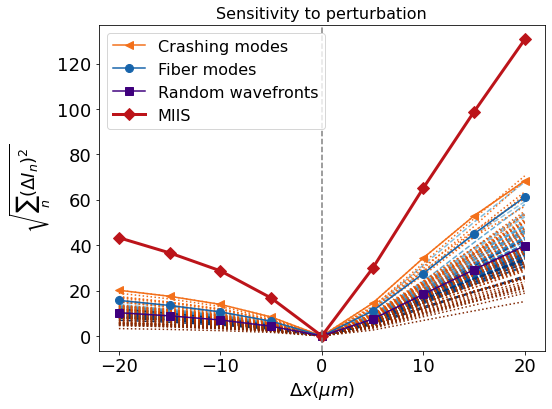

In [276]:
i0 = 8#center_TM_index-2#5#18
plt.figure(figsize = (8,6))
n_mod2p = n_mod#//3
n_cra2p = n_mod

dxp = (dx4corr[i0:] - dx4corr[12])*1000

fun_scale = lambda x : x**(1/2) 

for i in range(n_mod2p):
    plt.plot(dxp, fun_scale(chg_mod[i0:,i]), color=cmmod(0.4+0.6*i/n_mod2p), ls='--')


# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

for i in range(n_cra2p):
    plt.plot(dxp, fun_scale(chg_crash[i0:,i]), c=cmcra(0.6+0.4*i/n_cra2p), ls=':')#cmb(n_mod2p-i-1), ls='-')
plt.plot(dxp, fun_scale(chg_crash[i0:,2]), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

plt.plot(dxp, fun_scale(chg_mod[i0:,np.argmax(Fmod)]), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

plt.plot(dxp,fun_scale(np.mean(chg_rnd,axis=-1)[i0:]),c=crnd,markersize=8,marker='s',label='Random wavefronts')

plt.plot(dxp,fun_scale(chg_miis[i0:]),lw=3, c=cmii, markersize=8, marker='D',label='MIIS')

all_min = plt.gca().get_ylim()[0]
plt.gca().axvline(0, c='gray', linestyle = 'dashed')
plt.legend(loc=0)
# plt.yscale('log')
plt.xlabel('$\Delta x (\mu m)$')
plt.ylabel('$\sqrt{\sum_n (\Delta I_n)^2} $')
plt.title('Sensitivity to perturbation')

# 3. Pixel Fisher and out fields

Text(-0.18, 0.95, 'b')

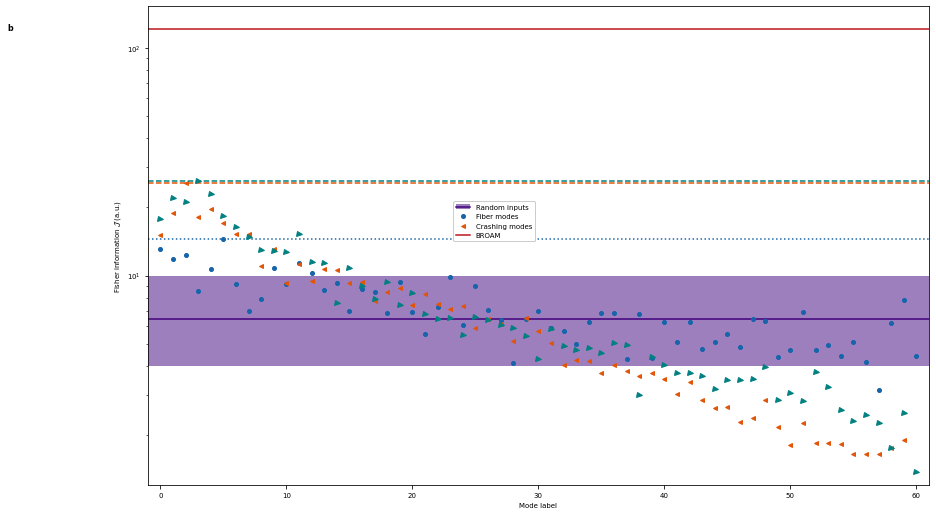

In [253]:
zf =4
fig, ax = plt.subplots(1,1, figsize=(zf*3.5,zf*2.2))
# ax2 = ax.twiny() 
ms = 4
# Random
# ln1, = ax2.plot(Frnd,'s',markersize=2, c=crnd)
ln1p = ax.fill_between(np.arange(-1,n_mod+1),np.max(Frnd), np.min(Frnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax.axhline(np.mean(Frnd), linestyle='-', c=crnd)
# Fiber modes
ln2, = ax.plot(np.arange(n_mod),Fmod,'o',markersize=ms, c=cmod)
ax.axhline(np.max(Fmod), linestyle=':', c=cmod)

# Crashing modes
ln3, = ax.plot(np.arange(n_mod),Fcrash[:n_mod],'<',markersize=ms, c=ccra)
ax.axhline(np.max(Fcrash), linestyle='--', c=ccra)

# Fw4 = fisher(Xw4, TMs4modes, noise=noise)
ax.plot(np.arange(n_mod),Fcrash_inw4[:n_mod],'>',markersize=5,  c='teal')
ax.axhline(np.max(Fcrash_inw4), linestyle='--', c='teal')

# Fw4 = fisher(Xw4, TMs4modes, noise=noise)
# ln3, = ax2.plot(np.arange(n_mod),Fw4[:n_mod],'>',markersize=5,  c='teal')
# ax.axhline(np.max(Fcrash), linestyle='--', c=ccra)

# MIIS
ln4 = ax.axhline(Fmiis, c=cmii)

lns = [(ln1,ln1p),ln2,ln3,ln4]
lgd =ax.legend(lns,['Random inputs','Fiber modes',
    'Crashing modes','BROAM'],
    bbox_to_anchor=(.5,.6), #bbox_to_anchor=(1.8,.5), 
    # loc=0, 
    facecolor='white',framealpha=1)
    
ax.set_xlabel('Mode label')
# ax2.set_xlabel('Random input label')
ax.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax.set_yscale('log')
ax.set_ylim(Fmiis *1e-2)
ax.set_xlim(-1.,n_mod-0.)
# t = ax.yaxis.get_offset_text()
# t.set_x(-10.1)
ax.text(-0.18,0.95, 'b', transform=ax.transAxes,  fontweight='bold')
# plt.savefig(os.path.join(fig_path,'fish_pix.pdf'),bbox_inches='tight')

In [158]:
Fpix_crash = fisherPerMode(Xcrash, TMs4modes, noise=noise)
Fpix_rnd = fisherPerMode(Xrnd, TMs4modes, noise=noise)
Fpix_mod = fisherPerMode(Xmod, TMs4modes, noise=noise)
Fpix_miis = fisherPerMode(Xmiis, TMs4modes, noise=noise)

In [159]:
Fpix_crash.shape

(61, 2888)

<ErrorbarContainer object of 3 artists>

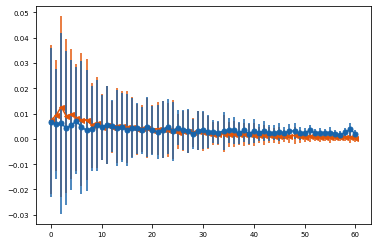

In [175]:
where_mask = (out_mask.ravel().astype('bool'))
plt.errorbar(np.arange(n_mod), np.mean(Fpix_crash, axis=1, where=where_mask), 
    np.std(Fpix_crash, axis=1, where=where_mask),marker='<',markersize=5, c=ccra)
# errorbar(x, y, e, linestyle='None', marker='^')
plt.errorbar(np.arange(n_mod), np.mean(Fpix_mod, axis=1, where=where_mask), 
    np.std(Fpix_crash, axis=1, where=where_mask),marker='o',markersize=5, c=cmod)
# plt.plot(np.mean(Fpix_mod, axis=1),'o',markersize=5, c=cmod)

In [179]:
np.mean(Fpix_miis)

0.041758555629908226

In [23]:
# Xins = [Xmiis,Xcrash[np.argmax(Fcrash)],Xmod[np.argmax(Fmod)],Xrnd[0]]
X4est = np.load(os.path.join(data_path,'Xestimate.npy'))
TMs4fieldplot = np.array([TMlist4corr[12], TMlist4corr[12+4]])
Yints4p = np.abs(getOutputFields(X4est[::-1], TMs4fieldplot))**2
Yints4p /= np.max(Yints4p)

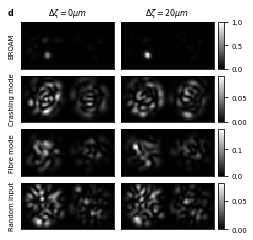

In [228]:
from matplotlib import cbook
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure(figsize=(8,8))
titles = ['Random input', 'Fibre mode', 'Crashing mode', 'BROAM']
"""
A grid of 2x2 images. Each row has its own colorbar.
"""
grid = AxesGrid(fig, 122,  # similar to subplot(122)
                nrows_ncols=(4, 2),
                axes_pad=0.10,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="edge",
                cbar_size="7%",
                cbar_pad="4%",
                )
# Z, extent = get_demo_image()
cmaps = ["spring", "winter"]
for i in range(4):
    curr_max = np.max(Yints4p[:,i])
    for j in range(2):
        ig = 2*i +j
    
        if j<1:
            im = grid[ig].imshow(horz_reshp(Yints4p[j,i]),vmin=0,vmax=curr_max,cmap=cmap_int,
                            interpolation='none')
            grid[ig].text(-0.1,0.5, titles[-1-i],transform = grid[ig].transAxes,
                horizontalalignment='center',verticalalignment='center',fontsize=SMALL_SIZE,
                rotation=90)
        if j==1:
            im = grid[ig].imshow(horz_reshp(Yints4p[j,i]),vmin=0,vmax=curr_max,cmap=cmap_int,
                            interpolation='none')
            grid.cbar_axes[i].colorbar(im)
        grid[ig].tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
for cax in grid.cbar_axes:
    cax.toggle_label(True)
    # cax.axis[cax.orientation].set_label('Foo')
grid[0].text(-0.15,1.15, 'd', transform=grid[0].transAxes,  fontweight='bold')
grid[1].text(0.5,1.2, '$\Delta \zeta = 20 \mu m$',transform = grid[1].transAxes,
            horizontalalignment='center',verticalalignment='center',fontsize=MEDIUM_SIZE)
grid[0].text(0.5,1.2, '$\Delta \zeta = 0 \mu m$',transform = grid[0].transAxes,
            horizontalalignment='center',verticalalignment='center',fontsize=MEDIUM_SIZE)

plt.savefig(os.path.join(fig_path,'fields_vs_def.pdf'),bbox_inches='tight')

In [283]:
(Fmiis/np.max(Fcrash))**(1/2)

2.1695663610483815

In [68]:
Xins = [Xrnd[0],Xmod[np.argmax(Fmod)],Xcrash[np.argmax(Fcrash)],Xmiis]
# Xins = [Xrnd[0],Xmod[0],Xcrash[np.argmax(Fcrash)],Xmiis]
def get_intNdiff(X, H):
    Ys = getOutputFields(X, H)
    Intdiff = np.abs(Ys[-1])**2-np.abs(Ys[0])**2
    return np.abs(Ys[1])**2, Intdiff

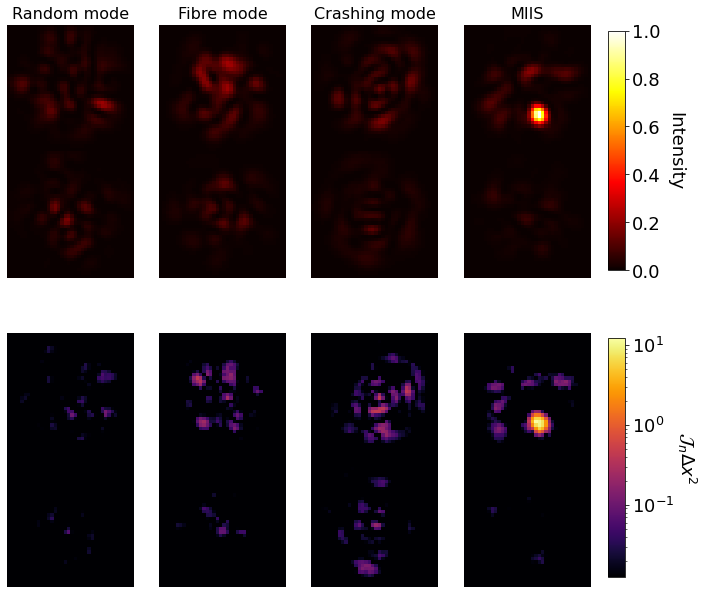

In [251]:
Yint, Ydiff = get_intNdiff(Xins, TMs4modes)

fmax= np.max((np.abs(Ydiff)**2).ravel())
fmin = fmax*(10**(-3))
dm = np.max(Ydiff[3])
Im = np.max(Yint.ravel())
Yint /= Im
Ydiff[np.abs(Ydiff)==0] = fmin**(1/2)
titles = ['Random mode', 'Fibre mode', 'Crashing mode', 'MIIS']
fig, axs = plt.subplots(2,4,figsize=(0.8*15,1.6*6.5))

# axs[0,0].set_ylabel('Field Intensity')

for i in range(4):
    axs[0,i].set_title(titles[i])
    if i<3:
        axs[0,i].imshow(Yint[i].reshape(2*N_out,N_out),vmin=0,vmax=1,cmap=cmap_int)
        axs[1,i].matshow((np.abs(Ydiff[i]).reshape(2*N_out,N_out))**2,
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish)
    else:
        pl_int = axs[0,i].imshow(Yint[i].reshape(2*N_out,N_out),vmin=0,vmax=1,cmap=cmap_int)
        pl_fish = axs[1,i].matshow((np.abs(Ydiff[i]).reshape(2*N_out,N_out))**2,
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish)
    

cb_width =0.02
cb_height = 0.32
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.14+0.41, cb_width, cb_height])
cbar1= fig.colorbar(pl_int, cax=cbar_ax)
cbar_ax.get_yaxis().labelpad = 24
cbar1.set_label('Intensity', rotation=270)

cbar_ax2 = fig.add_axes([0.82, 0.14, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2)
cbar_ax2.get_yaxis().labelpad = 24
cbar2.set_label('$\mathcal{J}_n\Delta x^2$', rotation=270)

for ax in axs.ravel():
    ax.axis('off')

# 4. Estimating change in perturbation

In [25]:
def estimate_def(Imeas, Iref0, Ider, mui=1, mud=1):
    der = mud*Ider
    deformation = np.sum(der *(Imeas-mui * Iref0), axis=-1)/np.sum(der**2, axis=-1)
    return deformation

In [26]:
I4der_3pts = np.load(os.path.join(data_path,'I4der_3pts.npy'))
Iest_vecs = np.load(os.path.join(data_path,'Iest_vecs.npy'))
amps = np.load(os.path.join(data_path,'amps4est.npy'))
pos4est = np.load(os.path.join(data_path,'pos4est.npy'))

In [524]:
I4der_means = np.mean(I4der_3pts, axis=1)
# Iders = (I4der_means[-1] - I4der_means[0])/(2*del_x)

ind_der_pm = 4#4
ind_der_0 = 4
Idiffs = (np.mean(Iest_vecs[ind_der_0+ind_der_pm,:,0], axis=0)-np.mean(Iest_vecs[ind_der_0-ind_der_pm,:,0], axis=0))
delx4der = (pos4est[ind_der_0+ind_der_pm]-pos4est[ind_der_0-ind_der_pm])
Iders = Idiffs/delx4der
Irefs0 = np.mean(Iest_vecs[ind_der_0,:], axis=0)
mui = (amps**2)[:,None,None]
mud = (amps**2)[:,None,None]

def_est_int = estimate_def(Iest_vecs, Irefs0, Iders, mui=1, mud=mud)

In [533]:
(np.sum(np.abs(Idiffs)**2, axis=1)/np.sum(np.abs(Idiffs[0])**2))**(1/2)

array([1.        , 1.41099577, 1.5951509 , 4.17698552])

In [543]:
1/(1000*np.std(def_est_int[6,:,3],axis=0))

array([0.64835043, 0.6591631 , 1.20849608, 2.69490684])

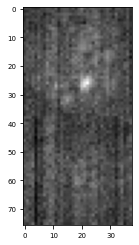

In [493]:
plt.imshow(np.mean(Irefs0[4],axis=0).reshape(2*N_out,N_out),cmap=cmap_int)

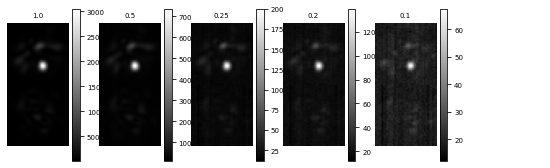

In [494]:
fig, axs = plt.subplots(1,6,figsize=(0.8*12,0.8*3.5))
titles = ['init','als4', 'pw4']
for i in range(5):
    axs[i].set_title(str(amps[i]))
    im = axs[i].imshow(Irefs0[i,3].reshape(2*N_out,N_out),cmap=cmap_int)
    fig.colorbar(im, ax=axs[i])
for ax in axs.ravel():
    ax.axis('off')

In [474]:
Irefs0.shape

(5, 4, 2888)

In [476]:
amps**2

array([1.    , 0.25  , 0.0625, 0.04  , 0.01  ])

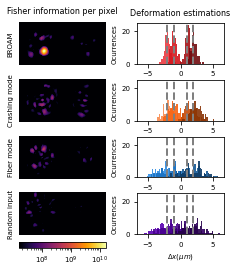

In [31]:
i_def_list = np.array([0,2,6,8])
# i_def_list = np.array([1,3,5,7])

fmax= np.max((np.abs(Iders)**2).ravel())
fmin = fmax*(10**(-3))
Iders[np.abs(Iders)==0] = fmin**(1/2)

ld_list = np.linspace(1.4,0.6,len(i_def_list))
ind_amp = 3

fig, axs = plt.subplots(4,2,figsize=(3.15,4))
chist = [crnd, cmod, ccra, cmii]
labels = ['Random input', 'Fiber mode', 'Crashing mode', 'BROAM']
lw=4
target_def_list = pos4est[i_def_list]  - pos4est[4]
xmin = 1000*target_def_list[0]-4
xmax = 1000*target_def_list[-1]+4
bins = np.linspace(xmin,xmax,60)
for ip in range(4):
    ipn = -1-ip
    pl_fish = axs[ip,0].matshow((np.abs(horz_reshp(Iders[ipn]))**2),
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish,
                        interpolation=None)
    axs[ip,0].axis('off')
    axs[ip,0].set_ylabel(labels[ipn])
    axs[ip,0].text(-0.1,.5, labels[ipn],transform = axs[ip,0].transAxes,
     horizontalalignment='center', fontsize=SMALL_SIZE,
     verticalalignment='center', rotation=90)
    #  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    axs[ip,1].set_ylim(0,25)
    axs[ip,1].set_ylabel('Ocurrences')
    
    if ip==3:
        axs[ip,1].set_xlabel('$\Delta x (\mu m)$')

    for n, i_def in enumerate(i_def_list):

        xvar = 1000*def_est_int[i_def,:,ind_amp,ipn]
        # counts, bins = np.histogram(xvar)
        axs[ip,1].hist(xvar, bins, alpha=0.9, 
            color=adjust_lightness(chist[ipn], amount=ld_list[n]))
        # ax.axvline(x=np.mean(xvar), c=adjust_lightness(chist[ip], amount=ld_list[n]),linewidth=lw)
        axs[ip,1].axvline(x=1000*target_def_list[n], c='gray',linewidth=0.5*lw, ls='--')
    axs[ip,1].set_aspect(1/4)

    # axs[ind_p].text(-0.2,0.95,nb_lb[ind_p], transform=axs[ind_p].transAxes, fontweight='bold')

cb_width =0.38
cb_height = 0.02
cbar_ax2 = fig.add_axes([0., 0.09, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2, orientation='horizontal')
cbar_ax2.get_yaxis().labelpad = 24
# cbar2.set_label('$\mathcal{J}_n$(a.u.)', rotation=0)

axs[0,0].text(0.5,1.25, 'Fisher information per pixel',transform = axs[0,0].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center')
axs[0,1].text(0.5,1.25, 'Deformation estimations',transform = axs[0,1].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center')
# plt.tight_layout(pad=0., w_pad=0., h_pad=.02)
# plt.tight_layouplt.adjust
plt.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=0.37, hspace=None)

plt.savefig(os.path.join(fig_path,'Est_def.pdf'),bbox_inches='tight')

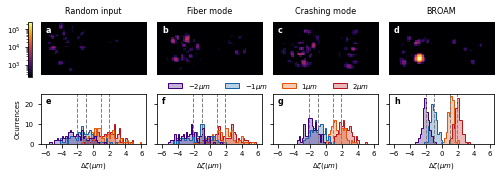

In [473]:
i_def_list = np.array([0,2,6,8])
# i_def_list = np.array([1,3,5,7])
nb_lb = [['a','b','c','d'],['e','f','g','h']]
fmax= np.max((np.abs(Idiffs)**2).ravel())
fmin = 0.8*fmax*(10**(-3))
Idiffs[np.abs(Idiffs)==0] = fmin**(1/2)

ld_list = np.linspace(1.4,0.6,len(i_def_list))
ind_amp = 3

fig, axs = plt.subplots(2,4,figsize=(7.,2.3))
chist = [crnd, cmod, ccra, cmii]
alpha = 0.3
cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]

labels = ['Random input', 'Fiber mode', 'Crashing mode', 'BROAM']
lw=1
target_def_list = pos4est[i_def_list]  - pos4est[4]
xmin = 1000*target_def_list[0]-4
xmax = 1000*target_def_list[-1]+4
bins = np.linspace(xmin,xmax,60)
for ip in range(4):
    pl_fish = axs[0,ip].matshow((np.abs(horz_reshp(Idiffs[ip]))**2),
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish,
                        interpolation='none')

    axs[0,ip].axis('off')
    axs[0,ip].set_ylabel(labels[ip])
    axs[0,ip].text(0.5,1.2, labels[ip],transform = axs[0,ip].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    #  bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    if ip>0:
        axs[1,ip].axes.yaxis.set_ticklabels([])

    axs[1,ip].set_ylim(0,25)
    # axs[1,ip].set_ylabel('Ocurrences')
    
    axs[1,ip].set_xlabel('$\Delta \zeta (\mu m)$')
    xvar = 1000*def_est_int[i_def_list,:,ind_amp,ip].T
    axs[1,ip].hist(xvar, bins, color=chist, histtype='step',lw=lw)
    axs[1,ip].hist(xvar, bins, color=chist, alpha=alpha,  histtype='stepfilled')
    
    for n, i_def in enumerate(i_def_list):

        # xvar = 1000*def_est_int[i_def,:,ind_amp,ip]
        # counts, bins = np.histogram(xvar)
        # axs[1,ip].hist(xvar, bins, alpha=0.9, 
        #     color=adjust_lightness(chist[ip], amount=ld_list[n]))
        # ax.axvline(x=np.mean(xvar), c=adjust_lightness(chist[ip], amount=ld_list[n]),linewidth=lw)
        axs[1,ip].axvline(x=1000*target_def_list[n], c='gray',linewidth=lw, ls='--')
    axs[1,ip].set_aspect(1/4)
    axs[1,ip].set_xticks(np.arange(-6,8,2))
    axs[0,ip].text(0.05,0.8,nb_lb[0][ip], transform=axs[0,ip].transAxes, color='w', fontweight='bold')
    axs[1,ip].text(0.05,0.8,nb_lb[1][ip], transform=axs[1,ip].transAxes,  fontweight='bold')
    # axs[ind_p].text(-0.2,0.95,nb_lb[ind_p], transform=axs[ind_p].transAxes, fontweight='bold')
axs[1,0].set_ylabel('Ocurrences')

handles = [matplotlib.patches.Rectangle((0,0),.1,.1,color=cf[i],ec=chist[i]) for i in range(4)]
labels= ["$-2\mu m$","$-1\mu m$", "$1\mu m$",'$2\mu m$']
fig.legend(handles, labels, fontsize=SMALL_SIZE, ncol=4, loc=(0.33,0.47), frameon=False)
# ax.legend(markerscale=.5)
cb_width =0.007
cb_height = 0.334
cbar_ax2 = fig.add_axes([-0.025, 0.54, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2, orientation='vertical')
cbar_ax2.yaxis.set_ticks_position('left')

# cbar_ax2.get_yaxis().labelpad = 24
# cbar2.set_label('$\mathcal{J}_n$(a.u.)', rotation=0)

plt.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

plt.savefig(os.path.join(fig_path,'Est_def.pdf'),bbox_inches='tight',dpi=400)

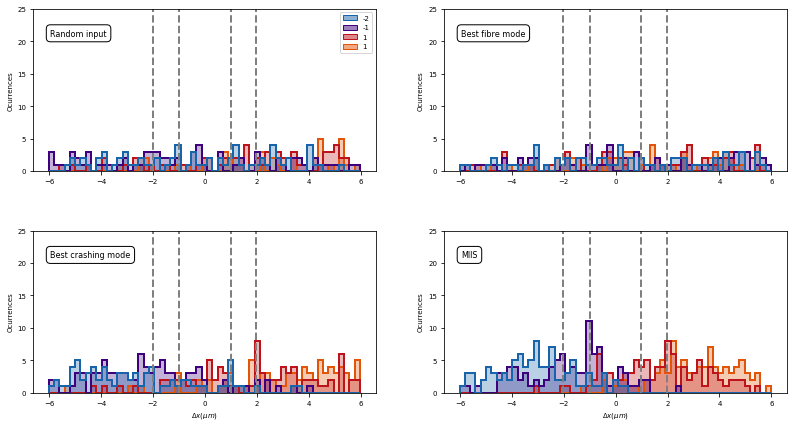

In [531]:
i_def_list = np.array([0,2,6,8])
# i_def_list = np.array([1,3,5,7])

ld_list = np.linspace(1.4,0.6,len(i_def_list))
ind_amp = 4

fig, axs = plt.subplots(2,2,figsize=(0.9*15,0.65*11.5))
chist = [cmod, crnd, cmii, ccra]
cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),0.5)]
labels = ['Random input', 'Best fibre mode', 'Best crashing mode', 'MIIS']
lw=4
target_def_list = pos4est[i_def_list]  - pos4est[4]
xmin = 1000*target_def_list[0]-4
xmax = 1000*target_def_list[-1]+4
bins = np.linspace(xmin,xmax,60)
for ip, ax in enumerate(axs.ravel()):
    ax.set_ylim(0,25)
    ax.set_ylabel('Ocurrences')
    ax.text(0.05,.85, labels[ip],transform = ax.transAxes,
     horizontalalignment='left',
     verticalalignment='center',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    if ip>1:
        ax.set_xlabel('$\Delta x (\mu m)$')

    ax.hist(1000*def_est_int[i_def_list,:,ind_amp,ip].T, bins, color=chist, alpha=1, histtype='step',lw=2)
    ax.hist(1000*def_est_int[i_def_list,:,ind_amp,ip].T, bins, color=chist, alpha=.3,  histtype='stepfilled',lw=2)
    for n, i_def in enumerate(i_def_list):

        xvar = 1000*def_est_int[i_def,:,ind_amp,ip]
        # counts, bins = np.histogram(xvar)
        
        
        # ax.hist(xvar, bins,   lw=5,fc=cf[n])
        # ax.hist(xvar, bins, alpha=0.5, color=adjust_lightness(chist[ip], amount=ld_list[n]), histtype='step')
        # ax.axvline(x=np.mean(xvar), c=adjust_lightness(chist[ip], amount=ld_list[n]),linewidth=lw)
        ax.axvline(x=1000*target_def_list[n], c='gray',linewidth=0.5*lw, ls='--')
    ax.set_aspect(1/4)
handles = [matplotlib.patches.Rectangle((0,0),1,1,color=cf[i],ec=chist[i]) for i in range(4)]
labels= ["-2","-1", "1",'1']
axs[0,0].legend(handles, labels)
    # ax.set_title('a',c='w')
    # ax.set_xlim(0*xmin,xmax)
# plt.subplots_adjust(wspace=1.5)

# fig.tight_layout(rect=(0,0,1,1))

# 5. Optimal output modes

## 5.1 MOIM for previous 

Change basis to speed things up

In [33]:
udef, sdef, vhdef = np.linalg.svd(TMs4modes[1])
TMs_svd = udef[:,:len(sdef)].T.conj() @ TMs4modes
mofish = lambda mo : np.sum(np.abs(mo[1])**2, axis=-1)

In [34]:
Fmo_rnd = []
for ind in range(n_rnd//50):
    _, vals_rnd = get_moim(Xrnd[ind*50:(ind+1)*50], TMs_svd[::2])
    Fmo_rnd += np.sum(np.abs(vals_rnd)**2, axis=-1).tolist()

In [46]:
MOmod = get_moim(Xmod, TMs_svd[::2])
# MOcrash = get_moim(Xcrash, TMs_svd[::2])
MOmiis = get_moim(Xmiis, TMs_svd[::2])

Fmo_mod = mofish(MOmod)
# Fmo_crash = mofish(MOcrash)

In [35]:
MOmod = get_moim(Xmod, TMs4modes[::2])
# MOcrash = get_moim(Xcrash, TMs_svd[::2])
MOmiis = get_moim(Xmiis, TMs4modes[::2])

Fmo_mod = mofish(MOmod)
# Fmo_crash = mofish(MOcrash)

In [37]:
MOmiis2 = get_moim(Xmiis, TMs_svd[::2])
mofish(MOmiis2)

11190.14771790933

In [36]:
mofish(MOmiis)

20789.686164490508

## 5.2 Precision limit

In [38]:
W4th_tensor = get_W4(TMs_svd.astype(np.csingle))
uw4s, sw4 = hosvd(W4th_tensor)
Xw4 = uw4s[3].T
MOw4 = get_moim(Xw4, TMs_svd[::2])
Fmo_w4 = mofish(MOw4)

In [570]:
udef[:,:len(sdef)].shape

(2888, 900)

In [571]:
W3_svd = get_W3(udef[:,:len(sdef)]@ udef[:,:len(sdef)].T.conj() @ TMs4modes, method='2pts') 

In [572]:
us_hosvd_p, s_hosvd_p = hosvd(W3_svd)
Xcrash_p = us_hosvd_p[2].T

In [39]:
optw4_seeds = [Xw4[i] for i in range(10)]
Flim, Xlim, evol, nseed = get_lim(optw4_seeds, TMs_svd[::2], n_iter=200)

In [759]:
optw4_seeds = [Xw4[i] for i in range(1)]
Flimnp, Xlimnp, evolnp, nseednp = get_lim(optw4_seeds, TMs4modes[::2], n_iter=20)

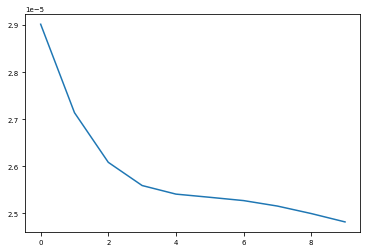

In [768]:
plt.plot(evolnp)

In [762]:
Flimnp

40295.558760858155

## 5.3 Best one out

In [346]:
als4_seeds = [[uw4s[0][:,0,None],uw4s[1][:,0,None],uw4s[2][:,0,None],uw4s[3][:,0,None]]]
Fb1out, Xb1out, evol_als, nseed = get_best1out(als4_seeds, TMs_svd[::2], W4th_tensor,n_iter=50)

In [361]:
from numba import jit

In [373]:
@jit(nopython=True)
def test(x, max_iter, init_vecs, evol=False):
    norm_x = np.sum(np.abs(x)**2)**(1/2)
    outvec = init_vecs[0]
    invec = init_vecs[1]
    l_out = len(outvec)
    l_in = len(invec)

    cost_evol = np.zeros(max_iter)
    for n_iter in range(max_iter):
        invec = np.sum(np.sum(np.sum(x * outvec.reshape(l_out,1,1,1).conj() 
            * outvec.reshape(l_out,1,1) * invec.reshape(l_in,1)
            , axis=0), axis=0), axis=0)
        invec /= np.sum(np.abs(invec)**2)**(1/2)

        outvec = np.sum(np.sum(np.sum(x * outvec.reshape(l_out,1,1) * invec.reshape(l_in,1) * invec.conj()
            , axis=1), axis=1), axis=1)
        lam = np.sum(np.abs(outvec)**2)**(1/2)
        outvec /= lam
        
        if evol:
            x_approx = lam*outvec.reshape(l_out,1,1,1)*outvec.reshape(l_out,1,1).conj()*invec.reshape(l_in,1).conj()*invec
            cost_evol[n_iter] = np.sum(np.abs(x-x_approx)**2)**(1/2)/norm_x
    return [outvec, invec], cost_evol

In [383]:
outNx, evol = test(W4th_tensor, 50, np.array([uw4s[0][:,0].conj(),uw4s[3][:,0].conj()]), evol=True)

In [358]:
from pyTen.decompositions import power4herm

outNx, evol = power4herm(W4th_tensor, 50, [uw4s[0][:,0].conj(),uw4s[3][:,0].conj()], evol=True)

In [303]:
def get_fisher_b1out(X,Hs):
    moim = get_moim(X,Hs)
    return moim[1][1]**2

In [328]:
get_fisher_b1out(Xb1out,TMs_svd[::2])

19209.11312442979

In [324]:
get_fisher_b1out(uw4s[3][:,0],TMs_svd[::2])

15087.07215920281

In [342]:
get_fisher_b1out(outNx[1],TMs_svd[::2])

19209.112870477937

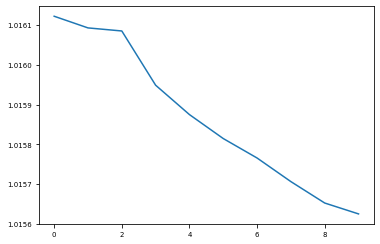

In [380]:
plt.plot(evol)
# plt.plot(evol_als)

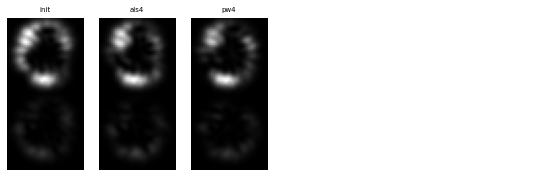

In [379]:
Ysb1o =getOutputFields(np.array([uw4s[3][:,0],Xb1out,outNx[1]]), TMs4modes[1])

fig, axs = plt.subplots(1,6,figsize=(0.8*12,0.8*3.5))
titles = ['init','als4', 'pw4']
for i in range(len(Ysb1o)):
    axs[i].set_title(titles[i])
    axs[i].imshow(np.abs(Ysb1o[i].reshape(2*N_out,N_out))**2,cmap=cmap_int)
for ax in axs.ravel():
    ax.axis('off')

In [42]:
Fb1onp, Xb1onp, evolb1onp, nseedb1onp = get_b1o_np(optw4_seeds, TMs_svd[::2], n_iter=200)

In [770]:
Fb1onp, Xb1onp, evolb1onp, nseedb1onp = get_b1o_np(optw4_seeds, TMs4modes[::2], n_iter=20)

## 5.4 Plot results

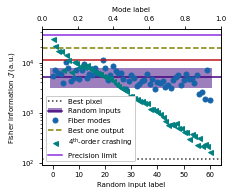

In [574]:
fig, ax = plt.subplots(1,1, figsize=(3.2,2.5))
ax2 = ax.twiny() 

# Best pix
l0 = ax.axhline(Fmiis, linestyle=':', color=adjust_lightness('gray', amount=.4))

# Random
# ln1, = ax2.plot(Fmo_rnd,'s',markersize=2, c=crnd)
ln1p = ax.fill_between(np.arange(-1,n_mod+1),np.max(Fmo_rnd), np.min(Fmo_rnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax.axhline(np.mean(Fmo_rnd), linestyle='-', c=crnd) 

# Fiber modes
ln2, = ax.plot(np.arange(n_mod), Fmo_mod,'o',markersize=5, c=cmod)
# ax.axhline(np.max(Fmo_mod), linestyle=':', c=cmod)

# Crashing modes
# ln3, = ax2.plot(np.arange(n_mod), Fmo_crash,'<',markersize=5, c=ccra)
# ax.axhline(np.max(Fmo_crash), linestyle='--', c=ccra)

# MIIS
ln4 = ax.axhline(mofish(MOmiis), c=cmii)

# best 1 out
ln3 = ax.axhline(Fb1out, c='olive', linestyle='--')

# sing W4
ln5, = ax.plot(np.arange(n_mod), Fmo_w4,'<',markersize=5, c='teal')
ln6 = ax.axhline(Flim, c='blueviolet')

lns = [l0,(ln1p,ln1),ln2,ln3,ln5,ln6]
lgd =ax2.legend(lns,['Best pixel','Random inputs','Fiber modes',
    'Best one output','4${}^\mathregular{th}$-order crashing','Precision limit'],
    # bbox_to_anchor=(1.,.5), #bbox_to_anchor=(1.8,.5), 
    loc=3, facecolor='white',framealpha=1)
    
ax2.set_xlabel('Mode label')
ax.set_xlabel('Random input label')
ax.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax.set_yscale('log')

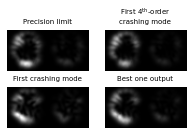

In [573]:
Ysbest = np.abs(getOutputFields(np.array([Xlim,Xw4[0],Xcrash[0],Xcrash_p[0]]), TMs4modes[1]))**2
Ysbest /= np.max(Ysbest)
fig, axs = plt.subplots(2,2,figsize=(3.2,0.6*3.2))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order\ncrashing mode', 
    'First crashing mode','Best one output']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.imshow(horz_reshp(Ysbest[i]),cmap=cmap_int, vmin=0,vmax=1)

    ax.axis('off')

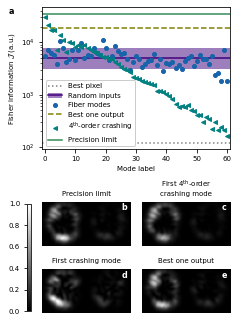

In [223]:
from matplotlib.gridspec import GridSpec
ms=4

nb_lb = ['a','b','c','d','e']
fig = plt.figure(figsize=(3.2, 2.5+0.6*3.2), layout="constrained")

gs = GridSpec(3, 2, figure=fig, height_ratios=[2.5,1,1])
ax1 = fig.add_subplot(gs[0, :])
# ax1t = ax1.twiny() 

# Best pix
l0 = ax1.axhline(Fmiis, linestyle=':', color='gray')
# Random
# ln1, = ax1t.plot(Fmo_rnd,'s',markersize=2, c=crnd)
ln1p = ax1.fill_between(np.arange(-1,n_mod+1),np.max(Fmo_rnd), np.min(Fmo_rnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax1.axhline(np.mean(Fmo_rnd), linestyle='-', c=crnd) 

# Fiber modes
ln2, = ax1.plot(np.arange(n_mod), Fmo_mod,'o',markersize=ms, c=cmod)
# ax.axhline(np.max(Fmo_mod), linestyle=':', c=cmod)
# best 1 out
ln3 = ax1.axhline(Fb1out, c='olive', linestyle='--')
# sing W4
ln5, = ax1.plot(np.arange(n_mod), Fmo_w4,'<',markersize=ms, c='teal')
ln6 = ax1.axhline(Flim, c='seagreen')

lns = [l0,(ln1p,ln1),ln2,ln3,ln5,ln6]
lgd =ax1.legend(lns,['Best pixel','Random inputs','Fiber modes',
    'Best one output','4${}^\mathregular{th}$-order crashing','Precision limit'],
    # bbox_to_anchor=(1.,.5), #bbox_to_anchor=(1.8,.5), 
    loc=3, facecolor='white',framealpha=1)
    
ax1.set_xlabel('Mode label')
# ax1.set_xlabel('Random input label')
ax1.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax1.set_yscale('log')
ax1.set_xlim(-1.,n_mod-0.)
ax1.text(-0.18,0.95, nb_lb[0], transform=ax1.transAxes,  fontweight='bold')

for i in range(2):
    for j in range(2):
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
        ax = fig.add_subplot(gs[i+1,j])
        ax.set_title(titles[2*i + j])
        im = ax.imshow(horz_reshp(Ysbest[2*i + j]), cmap=cmap_int, vmin=0,vmax=1)
        ax.axis('off')
        ax.text(0.9,0.8, nb_lb[2*i + j+1], transform=ax.transAxes,  fontweight='bold', color='w')
cb_width =0.017
cb_height = 0.338
cbar_ax2 = fig.add_axes([.1, 0.035, cb_width, cb_height])
cbar2=fig.colorbar(im, cax=cbar_ax2, orientation='vertical')
cbar_ax2.yaxis.set_ticks_position('left')

plt.savefig(os.path.join(fig_path,'Precision_lim.pdf'),bbox_inches='tight',dpi=400)

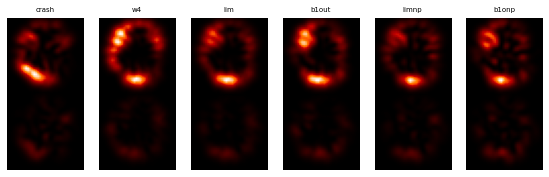

In [777]:
Ysbest =getOutputFields(np.array([Xcrash[0],Xw4[0],Xlim,Xb1out,Xlimnp,Xb1onp]), TMs4modes[1])

fig, axs = plt.subplots(1,6,figsize=(0.8*12,0.8*3.5))
titles = ['crash', 'w4', 'lim','b1out','limnp','b1onp']
for i in range(len(Ysbest)):
    axs[i].set_title(titles[i])
    axs[i].imshow(np.abs(Ysbest[i].reshape(2*N_out,N_out))**2,cmap=cmap_int)
for ax in axs.ravel():
    ax.axis('off')

Text(0, 0.5, 'Intensity correlation')

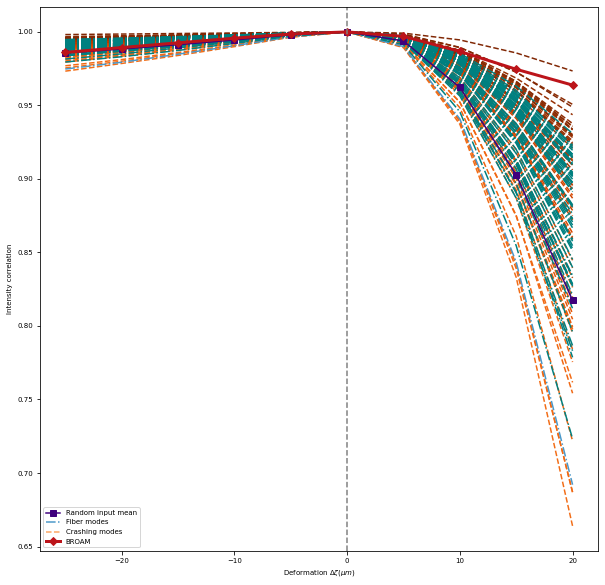

In [758]:
intc = False; rm=False
corr_crash = np.abs(get_corrVSdx(Xcrash, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc))
corr_w4 = np.abs(get_corrVSdx(Xw4, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc))

i0 = 7#center_TM_index-2#5#18
plt.figure(figsize = (10,10))
n_mod2p = n_mod#//3
n_cra2p = n_mod
ms = 6 #8

dxp = (dx4corr[i0:] - dx4corr[12])*1000



# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

ln3, = plt.plot(dxp, corr_crash[i0:,0], c=cmcra(0.4), ls='--',label='Crashing modes')
for i in range(n_cra2p):
    plt.plot(dxp, corr_crash[i0:,i], c=cmcra(0.6+0.4*i/n_cra2p), ls='--')#cmb(n_mod2p-i-1), ls='-')
# plt.plot(dxp, corr_crash[i0:,2], color=cmcra(0.6), ls='--', marker='<',markersize=ms, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

ln2, = plt.plot(dxp, corr_w4[i0:,0], color=cmmod(0.6), ls='-.',label='Fiber modes')
for i in range(1,n_mod2p):
    plt.plot(dxp, corr_w4[i0:,i], color='teal', ls='-.')
# plt.plot(dxp, corr_mod[i0:,np.argmax(Fmod)], color=cmod, ls=':',marker='o', markersize=ms, label='Fiber modes')
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

ln1, = plt.plot(dxp,np.mean(corr_rnd,axis=-1)[i0:],c=crnd,markersize=ms,marker='s',label='Random modes')

ln4, = plt.plot(dxp,corr_miis[i0:],lw=3, c=cmii, markersize=ms, marker='D',label='BROAM')

all_min = plt.gca().get_ylim()[0]
plt.gca().axvline(0, c='gray', linestyle = 'dashed')
plt.legend([ln1,ln2,ln3,ln4], ['Random input mean','Fiber modes',
    'Crashing modes','BROAM'], loc='lower left')

plt.xlabel('Deformation $\Delta \zeta (\mu m)$')
plt.ylabel('Intensity correlation')

# 6. Optimal output basis

In [587]:
@jit(nopython=True)
def get_outW4(W4):
    nout = W4.shape[0]
    outw4 = np.empty((nout,nout,nout,nout), dtype=np.complex64)
    for i in range(nout):
        for j in range(nout):
            for ip in range(nout):
                for jp in range(nout):
                    outw4[i,j,ip,jp] = np.sum(np.diag(W4[i,j])) *np.sum(np.diag(W4[ip,jp]))\
                         + np.sum(W4[i,j]*W4[ip,jp])
    return outw4

In [588]:
outW4 = get_outW4(W4th_tensor)

In [589]:
uoutw, soutw = hosvd(W4th_tensor)

In [591]:
np.sum(np.abs(uoutw[0][:,:n_moims])**2,axis=0, keepdims=True)

array([[1.        , 0.99999994, 0.99999994, 0.9999999 , 1.        ,
        1.0000002 , 0.99999994, 1.0000001 , 1.0000001 , 1.        ,
        1.0000001 , 1.0000001 , 1.0000001 , 0.99999994, 1.        ,
        0.99999976, 0.99999976, 1.        , 0.99999976, 0.9999998 ,
        0.99999994, 0.9999999 , 0.99999994, 1.        , 1.        ,
        0.99999994, 1.0000001 , 1.0000001 , 1.0000001 , 1.        ,
        1.        , 0.99999994, 1.        , 0.99999994, 1.0000001 ,
        1.0000001 , 1.0000002 , 0.9999999 , 1.0000002 , 0.9999999 ,
        1.0000001 , 0.99999994, 0.99999976, 0.99999994, 0.9999998 ,
        1.        , 1.        , 0.9999999 , 0.99999994, 1.0000001 ,
        1.        , 0.9999999 , 1.0000001 , 1.        , 1.        ,
        0.99999994, 0.99999994, 1.        , 1.0000001 , 1.        ,
        1.        ]], dtype=float32)

In [49]:
udef, sdef, vhdef = np.linalg.svd(TMpix)
TMs_modes = udef[:,:n_mod].T.conj() @ TMs4modes

n_moims = n_mod
sing_moims = uw4s[0][:,:n_moims]/(np.sum(np.abs(uw4s[0][:,:n_moims])**2,axis=0, keepdims=True))**(1/2)
TMs_hosvd = sing_moims.T.conj() @ TMs_svd


In [592]:
TMs_uni = uoutw[0][:,:n_moims].T.conj() @ TMs_svd

In [544]:
MOb1oi = get_moim(Xb1out,TMs_svd[::2])

In [547]:
TMs_b1o = MOb1oi[0].T.conj() @ TMs_svd

In [548]:
Frnd_b1o = fisherPerMode(Xrnd, TMs_b1o, noise=noise)

In [550]:
np.mean(Frnd_b1o, axis=0)

array([6.72002926, 8.12925231])

In [596]:
np.mean(Frnd_uni, axis=0)

array([6.72752942, 5.73694043, 4.46379369, 4.51573883, 1.24960715,
       2.98996488, 2.27042386, 2.22840203, 3.16470671, 2.79206992,
       1.75830224, 2.31743335, 2.23700482, 2.22758891, 2.02927451,
       1.71626438, 1.70536431, 1.6225597 , 1.61176489, 1.45526009,
       1.36520991, 1.29792975, 1.30164832, 1.06605808, 0.91175473,
       0.84059216, 0.84066174, 0.80610938, 0.67300528, 0.57652895,
       0.55318068, 0.5656104 , 0.50679633, 0.50003581, 0.44369974,
       0.37758859, 0.39165074, 0.33099174, 0.33027972, 0.32889454,
       0.25692038, 0.28335261, 0.23480959, 0.15773314, 0.21061277,
       0.21610611, 0.16061297, 0.15060669, 0.13012162, 0.17530614,
       0.11409342, 0.10101459, 0.09707184, 0.08579817, 0.11570312,
       0.10573091, 0.06949771, 0.10419066, 0.0516053 , 0.04963699,
       0.07368393])

In [553]:
np.mean(Frnd_hosvd, axis=0)

array([7.0052971 , 5.95003807, 4.6264986 , 4.41061797, 1.2024368 ,
       2.84638045, 2.37350789, 2.34296184, 3.13137585, 2.82612615,
       1.80828921, 2.27571878, 2.28174263, 2.14651025, 1.95698442,
       1.75334492, 1.74774408, 1.64389149, 1.6086824 , 1.40390045,
       1.37736659, 1.29983573, 1.201162  , 1.0614102 , 0.97087128,
       0.83279033, 0.80076451, 0.78671915, 0.70548955, 0.56873544,
       0.54336119, 0.57429619, 0.52189064, 0.51834154, 0.43683267,
       0.40162302, 0.37403287, 0.3213453 , 0.32952692, 0.32577579,
       0.26369161, 0.2822591 , 0.24204247, 0.15745171, 0.20289942,
       0.20498788, 0.15557827, 0.15175718, 0.13124119, 0.17407466,
       0.11601385, 0.10043356, 0.09683353, 0.08316364, 0.11584321,
       0.10790308, 0.07114514, 0.10329149, 0.05130237, 0.05175678,
       0.07054296])

In [561]:
n_rnd = 10000
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd_pix = fisher(Xrnd, TMs4modes, noise=noise)
Frnd_mod = fisherPerMode(Xrnd, TMs_modes, noise=noise)
Frnd_svd = fisherPerMode(Xrnd, TMs_svd, noise=noise)
Frnd_hosvd = fisherPerMode(Xrnd, TMs_hosvd, noise=noise)

In [593]:
Frnd_uni = fisherPerMode(Xrnd, TMs_uni, noise=noise)

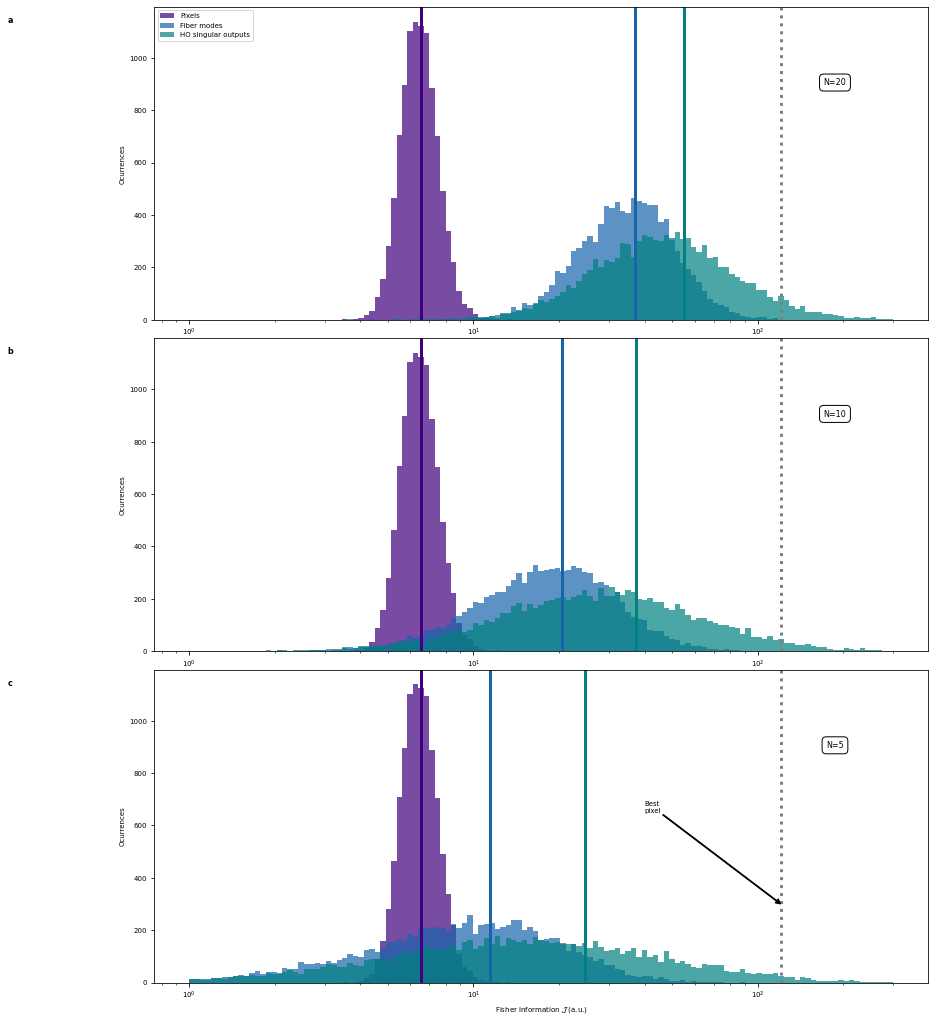

In [602]:
nb_lb = ['a','b','c','d']
# Fsrnd = np.array([Frnd_mod, Frnd_svd, Frnd_hosvd])
Fsrnd = np.array([Frnd_mod, Frnd_hosvd])
lw=3
zf=4
# lbs = ['Pixels', 'Fiber modes', 'SVD modes', 'HOSVD modes']
lbs = ['Pixels', 'Fiber modes', 'HO singular outputs']
# nlist = ['61','10','5']
chist = [crnd, cmod, 'teal', cmii]#ccra, cmii]
fig, axs = plt.subplots(3,1,figsize=(zf*3.15,zf*3.5))
bins = np.geomspace(1., Fsrnd.ravel().max(), 130)

for ind_p, n_outs in enumerate([20, 10, 5]):
    for i, d in enumerate([Frnd_pix, Frnd_mod, Frnd_hosvd]):
        if i != 0:
            vals_sort = np.argsort(np.mean(d, axis=0))
            dh=np.sum(d[:,vals_sort[-n_outs:]],axis=-1)
            # dh=np.sum(d[:,:n_outs],axis=-1)
        else:
            dh=d
        if ind_p==0:
            axs[ind_p].hist(dh, bins=bins, alpha=0.7, color=chist[i], label=lbs[i])
        else:
            axs[ind_p].hist(dh, bins=bins, alpha=0.7, color=chist[i])
        if i==3:
            axs[ind_p].axvline(x=np.mean(dh), c=chist[i],linewidth=lw,linestyle='--')
        else:
            axs[ind_p].axvline(x=np.mean(dh), c=chist[i],linewidth=lw)

    axs[ind_p].set_xscale('log')
    axs[ind_p].axvline(x=Fmiis, c='gray',linestyle=':',linewidth=lw)
    axs[ind_p].set_ylabel('Ocurrences')
    #     ax.text(0.05,.85, labels[ip],transform = ax.transAxes,
    #  horizontalalignment='left',
    #  verticalalignment='center',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    axs[ind_p].text(-0.19,0.95,nb_lb[ind_p], transform=axs[ind_p].transAxes, fontweight='bold')
    axs[ind_p].text(0.88,0.75,'N='+str(n_outs), fontsize=MEDIUM_SIZE, 
        horizontalalignment='center', transform = axs[ind_p].transAxes,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
axs[2].annotate('Best\npixel', xy=(Fmiis, 300), xytext=(40, 650), horizontalalignment='left',
            fontsize=SMALL_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))
axs[2].set_xlabel('Fisher information $\mathcal{J}$ (a.u.)')
axs[0].legend(loc='upper left')
plt.tight_layout(pad=0., w_pad=0., h_pad=.02)
# plt.savefig(os.path.join(fig_path,'Best_out_basis.pdf'),bbox_inches='tight')

In [559]:
Frnd_pix.shape

(10000,)

Text(0, 0.5, 'Ocurrences')

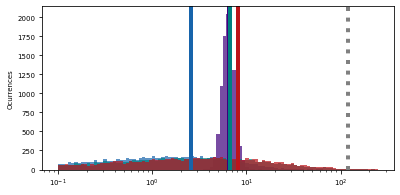

In [568]:
n_outs = 1
fig, axs = plt.subplots(figsize=(2*3.15,2*1.5))
chist = [crnd, cmod, 'teal', cmii]#ccra, cmii]

bins = np.geomspace(.1, Fsrnd.ravel().max(), 100)
for i, d in enumerate([Frnd_pix, Frnd_mod, Frnd_hosvd, Frnd_b1o]):
    if i != 0:
        vals_sort = np.argsort(np.mean(d, axis=0))
        dh=np.sum(d[:,vals_sort[-n_outs:]],axis=-1)
        # dh=np.sum(d[:,:n_outs],axis=-1)
    else:
        dh=d
    if ind_p==0:
        axs.hist(dh, bins=bins, alpha=0.7, color=chist[i], label=lbs[i])
    else:
        axs.hist(dh, bins=bins, alpha=0.7, color=chist[i])

    axs.axvline(x=np.mean(dh), c=chist[i],linewidth=lw)

axs.set_xscale('log')
axs.axvline(x=Fmiis, c='gray',linestyle=':',linewidth=lw)
axs.set_ylabel('Ocurrences')
